In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from numpy import genfromtxt
import numpy as np
import pandas as pd
import csv

interbankExposure = pd.read_csv('interbankExposures.csv', header=None)
bankEquities = pd.read_csv('bankEquities.csv', header=None)
bankExternalAsset = pd.read_csv('externalAssets.csv', header=None)


In [2]:
import sys, threading
sys.setrecursionlimit(10**7) # max depth of recursion
threading.stack_size(2**27)

0

In [3]:
##Get the interbank asset 
G = nx.DiGraph(interbankExposure.values)
nnodes = G.number_of_nodes() #145
out_degrees = [G.out_degree(n) for n in G.nodes()]
in_degrees = [G.in_degree(n) for n in G.nodes()]

# Get in-degree of each bank before shock applied 
in_Degree = pd.DataFrame(G.in_degree(weight= 'weight'))
in_Degree = in_Degree.T
in_Degree

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,0.00,1.0,2.0,3.0,4.00,5.0,6.0,7.0,8.00,9.00,...,135.00,136.0,137.00,138.00,139.0,140.0,141.0,142.00,143.0,144.0
1,538218.69,7351.7,39050.7,85674483.0,460659.54,1238360.5,16031089.0,95791798.0,753818.56,565121.06,...,133173.62,89665235.0,266487.57,951698.84,114617.8,75172808.0,71611906.0,303785.69,3836714.3,21025428.6


In [4]:
## Get the interbank liabilities
out_Degree = pd.DataFrame(G.out_degree(weight= 'weight'))
out_Degree = out_Degree.T
out_Degree

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,0.0,1.0,2.0,3.0,4.00,5.00,6.0,7.0,8.00,9.0,...,135.0,136.0,137.00,138.0,139.0,140.0,141.0,142.00,143.00,144.0
1,0.0,23025.0,23538.0,177169742.5,1084774.79,894264.49,9596575.2,155700407.0,982122.46,1187713.3,...,186295.8,7279935.1,231587.95,9066066.6,47821.0,43059152.3,101533088.0,589663.75,720921.42,24406140.7


In [5]:
## To computer external liabilities 
# External_liability = bankExteranlAsset + in degree - out_degree - bankEquities
external_liability = pd.DataFrame(index=range(1),columns=range(145))
external_liability= external_liability.add(bankExternalAsset, fill_value=0)
external_liability = external_liability.sub(bankEquities, fill_value=0)
external_liability = pd.DataFrame(external_liability.loc[0]+in_Degree.loc[1])
external_liability = pd.DataFrame(external_liability[0]-out_Degree.loc[1])
external_liability=external_liability.T
external_liability
#drop negative external_liability banks 
notdefaulted_external_liability = external_liability[external_liability[:]>0].dropna(axis=1)
defautled_external_liability = external_liability[external_liability[:]<=0].dropna(axis=1)


In [6]:
#applied shock to system
defaulters = pd.DataFrame(index=range(1),columns=range(145))
notdefaulters = pd.DataFrame(index=range(1),columns=range(145))


In [7]:
##Get defaulters and not_defaulters lists
bankEquities = bankEquities.reindex(notdefaulted_external_liability.columns,axis=1)
notdefaulters = notdefaulters.reindex(notdefaulted_external_liability.columns,axis=1)
defaulters = notdefaulters.reindex(defautled_external_liability.columns,axis=1)
notdefaulters

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,139,140,141,142,143,144
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
shock =560000#assume every bank hit by the same amount
for i in bankEquities: 
    bankEquities[i] = bankEquities[i]- shock
bankEquities

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,139,140,141,142,143,144
0,-94290.0,-555563.3,-546841,15669000.0,-121580.0,-288700.0,7012800.0,13707000.0,-460420,-381680.0,...,-113950.0,-527188,31563000.0,139090.0,-545741,10822000.0,13473000.0,-430570.0,314880.0,26295000.0


In [9]:
notdefaulters = bankEquities[bankEquities.iloc[0:]>0]
notdefaulters = notdefaulters.dropna(axis=1)
notdefaulters


,3,6,7,13,20,21,25,27,29,31,...,128,129,131,132,136,137,140,141,143,144
0,15669000.0,7012800.0,13707000.0,3757500.0,1840900.0,466500.0,175790.0,47138000.0,2491400.0,9433200.0,...,26935000.0,5506700.0,585800.0,1068600.0,31563000.0,139090.0,10822000.0,13473000.0,314880.0,26295000.0


In [10]:
defaulters = bankEquities[bankEquities.iloc[0:]<=0]
defaulters = defaulters.dropna(axis=1)
defaulters

,0,1,2,4,5,8,9,12,14,15,...,118,119,123,126,130,133,134,135,139,142
0,-94290.0,-555563.3,-546841,-121580.0,-288700.0,-460420,-381680.0,-192480.0,-200680.0,-435720.0,...,-432070.0,-466206,-344090.0,-491349,-445070.0,-345500.0,-113950.0,-527188,-545741,-430570.0


In [11]:
##Create empty list for updated defaulters
newBankEquity = pd.DataFrame(index=range(1),columns=range(145))
newbanklist = pd.DataFrame(index=range(1),columns=range(145))
defaulteroutDegree = pd.DataFrame(index=range(1),columns=range(145))
notdefautled_external_liability=pd.DataFrame(index=range(1),columns=range(145))
notdefaulted_external_asset = pd.DataFrame(index=range(1),columns=range(145))
externalRatio = pd.DataFrame(index=range(1),columns=range(145))
defaulter_exteranl_asset = pd.DataFrame(index=range(1),columns=range(145))

externallliability = equity - externalasset -indegree + outdegree\
equity = externalasset + indegree - outdegre -externalliabilty

In [12]:
## incldue the external ratio for the bank
def furfine(externalRatio, notdefaulted_external_asset,notdefaulters, defaulters, newBankEquity, newbanklist,defaulteroutDegree,interbankExposure, bankExternalAsset,notdefaulted_external_liability, in_Degree, out_Degree):
    notdefaulters_inDegree = in_Degree.reindex(notdefaulters.columns,axis=1)
    notdefaulters_outDegree = out_Degree.reindex(notdefaulters.columns,axis=1)
    notdefaulted_external_liability = notdefaulted_external_liability.reindex(notdefaulters.columns,axis=1)
    notdefaulted_external_asset = bankExternalAsset.reindex(notdefaulters.columns,axis=1)
    defaulter_exteranl_asset = bankExternalAsset.reindex(defaulters.columns,axis=1)
    sumRatio = 0
    for i in defaulters:
        sumDebt = sum(interbankExposure.loc[i,0:])
        defaulteroutDegree[i] = sumDebt
    ### For Question 3 to consdier the external asset 
# #     defaulterSumAsset = bankExternalAsset.reindex(defaulters.columns,axis=1).sum(axis=1)
    sumExternalAsset = bankExternalAsset.sum(axis=1)
    for i in defaulters:
        externalRatio[i] = defaulter_exteranl_asset[i]/sumExternalAsset
        sumRatio+=externalRatio[i]
    for i in notdefaulted_external_asset:
        newBankEquity[i] = (1-sumRatio)*notdefaulted_external_asset[i]
    #update bankEquities = notdefautlers_bankExteranlAsset + in degree - defaulteroutdegree - out_degree - exteranl_liability 
    newBankEquity = newBankEquity.sub(notdefaulted_external_liability, fill_value=0)
    newBankEquity = newBankEquity.sub(defaulteroutDegree, fill_value=0)
    newBankEquity = pd.DataFrame(notdefaulters_inDegree.loc[1]+newBankEquity.loc[0])
    newBankEquity = pd.DataFrame(newBankEquity[0]-notdefaulters_outDegree.loc[1]).T
    newbanklist = newBankEquity[newBankEquity[:]>0].dropna(axis=1)
    if len(newbanklist.T)==len(notdefaulters.T):
        return newbanklist 
    else:
        newBankEquity = newbanklist
        defaulters = newBankEquity[newBankEquity[:]<=0].dropna(axis=0)
        notdefaulters = newBankEquity[newBankEquity[:]>0].dropna(axis=0)
        for i in newBankEquity:
            newBankEquity[i]=0
        return furfine(externalRatio, notdefaulted_external_asset,notdefaulters, defaulters, newBankEquity, newbanklist,defaulteroutDegree,interbankExposure, bankExternalAsset,notdefaulted_external_liability, in_Degree, out_Degree)



In [13]:
x = furfine(externalRatio, notdefaulted_external_asset,notdefaulters, defaulters, newBankEquity, newbanklist,defaulteroutDegree,interbankExposure, bankExternalAsset, notdefaulted_external_liability,in_Degree, out_Degree)
x

""
0


<AxesSubplot:xlabel='Shock', ylabel='Number of banks survived the shock'>

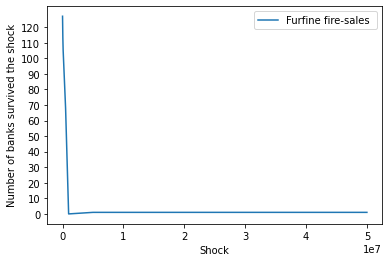

In [20]:
furfineGraph = pd.DataFrame({'Furfine fire-sales ': [127,113, 105,68,0,1,1,1],},
                  index=[0,50000,100000,500000,1000000,5000000,10000000,50000000])
furfineGraph.plot.line(yticks = range(0,130,10), xlabel='Shock', ylabel= 'Number of banks survived the shock')


<AxesSubplot:xlabel='Shock', ylabel='Number of banks survived the shock'>

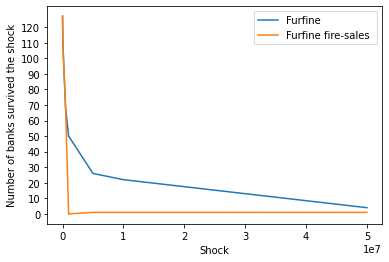

In [19]:
furfineGraph = pd.DataFrame({'Furfine': [127,113, 105,68,50, 26,22,4], 
                            'Furfine fire-sales ': [127,113, 105,68,0,1,1,1],},
                  index=[0,50000,100000,500000,1000000,5000000,10000000,50000000])
furfineGraph.plot.line(yticks = range(0,130,10), xlabel='Shock', ylabel= 'Number of banks survived the shock')
